In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import warnings
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

random.seed(1)

df = pd.read_csv('Datasets_Zrive/feature_frame.csv')

### Data Transformation

In [13]:
df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [14]:
#Filtering for Valid Orders
df_orders = df.groupby(by='order_id')['outcome'].sum()
valid_orders = df_orders[df_orders>=5].index.to_list() 
df = df[df['order_id'].isin(valid_orders)]
df

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [15]:
#Removing ID Variables and adding new features
df = df.drop(['created_at','user_id','variant_id','order_id'], axis=1)
df['order_date'] = pd.to_datetime(df['order_date'])
df['week_day']= df['order_date'].dt.weekday
df['month']= df['order_date'].dt.month
df['order_date'] = df['order_date'].dt.date

In [16]:
#Filtering for train, val and test by date.
df = df.sort_values(by='order_date')
df_date_cumsum = df.groupby('order_date')['outcome'].count().cumsum()/len(df)
df_val_index = df_date_cumsum[df_date_cumsum>0.7].index[0]
df_test_index = df_date_cumsum[df_date_cumsum>0.9].index[0]

print(f'Train split from {df_date_cumsum.index[0]}, till {df_val_index}')
print(f'Validation split from {df_val_index}, till {df_test_index}')
print(f'Test split from {df_test_index}, till {df_date_cumsum.index[-1]}')

Train split from 2020-10-05, till 2021-02-09
Validation split from 2021-02-09, till 2021-02-25
Test split from 2021-02-25, till 2021-03-03


In [17]:
df_train = df[df.order_date < df_val_index].drop(['order_date'], axis=1)
df_val = df[df.order_date.between(df_val_index,df_test_index, inclusive='left')].drop(['order_date'], axis=1)
df_test = df[df.order_date >= df_test_index].drop(['order_date'], axis=1)

In [18]:
print(len(df.vendor.value_counts()))
print(len(df.product_type.value_counts()))

264
62


In [19]:
df_categorical_features = ['product_type','vendor']
df_date_features = ['week_day','month']
df_numeric_features = ['user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price',
 'discount_pct', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type','std_days_to_buy_product_type']

### Main Models

In [20]:
def get_reg_model(penalty:str ,features: pd.DataFrame) -> GridSearchCV:
    '''
    Trains a Logistic Regression Model with the desired penalty and returns the model.
    '''
        
    param_grid = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': [penalty]}
    
    if penalty == "l1":
        param_grid['clf__solver'] = ['liblinear']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(features, df_train['outcome'])

    return grid_search

In [21]:
def draw_roc_prc(real_y: pd.Series, y_pred_list: np.ndarray, labels: list, xlim = [0.0, 1.0],ylim = [0.0, 1.05]):
    '''
    Plots a ROC and a Precision and Recall curve.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].set_title(f'ROC curve')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')

    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    
    fig.suptitle('ROC and PR curves for Models')

    colors = ['darkorange', 'blue', 'green', 'red', 'purple']

    for i, y_pred in enumerate(y_pred_list):
        fpr, tpr, thresholds = metrics.roc_curve(real_y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, color=colors[i], label=f'{labels[i]} (AUC = {roc_auc:.3f})')

        precision, recall, thresholds = metrics.precision_recall_curve(real_y, y_pred)
        average_precision = metrics.average_precision_score(real_y, y_pred)
        ax[1].plot(recall, precision, color=colors[i], label=f'{labels[i]} (AUC-PR = {average_precision:.3f})')

    ax[0].legend(loc='lower right')
    ax[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [22]:
#Linear Logistic Regression Models
grid_search_l1 = get_reg_model('l1', df_train.loc[:,df_numeric_features])
warnings.filterwarnings('ignore')

In [23]:
#FREQUENCY ENCODING of Categorical Variables for train and validation dataset

vendor_value_counts = df_train.vendor.value_counts()
product_type_counts = df_train.product_type.value_counts()

df_train['vendor'] = df_train['vendor'].apply(lambda x: vendor_value_counts.get(x, 0)).astype('int32')
df_train['product_type'] = df_train['product_type'].apply(lambda x: product_type_counts.get(x, 0)).astype('int32')

df_val['vendor'] = df_val['vendor'].apply(lambda x: vendor_value_counts.get(x, 0)).astype('int32')
df_val['product_type'] = df_val['product_type'].apply(lambda x: product_type_counts.get(x, 0)).astype('int32')

### Non-Linear Models

In [24]:
#Simple Decision Tree
def get_model_dec_tree(features: pd.DataFrame) -> RandomizedSearchCV:    
    param_grid = {
        'clf__criterion': ['gini','entropy'],
        'clf__max_depth': randint(1,50),
        'clf__min_samples_split': randint(2,15),
        'clf__min_samples_leaf': randint(1,10)}
    

    pipeline = Pipeline([
        ('clf', DecisionTreeClassifier())])

    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs=-1,random_state=1,n_iter=10)
    grid_search.fit(features, df_train['outcome'])

    return grid_search

In [25]:
grid_search_tree = get_model_dec_tree(df_train.loc[:,df_numeric_features])

In [26]:
grid_search_tree.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 7,
 'clf__min_samples_split': 11}

In [40]:
from sklearn.ensemble import BaggingClassifier

#Bagging Classifier
def get_model_bagging(features: pd.DataFrame) -> RandomizedSearchCV:    
    param_grid = {
        'clf__n_estimators': [30],
        'clf__max_samples': [0.5, 0.75, 1.0],
        'clf__max_features': [0.5, 0.75, 1.0]}

    pipeline = Pipeline([
        ('clf', BaggingClassifier())])

    grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1)
    grid_search.fit(features, df_train['outcome'])

    return grid_search

In [41]:
grid_search_bagging = get_model_bagging(df_train.loc[:,df_numeric_features])

In [43]:
grid_search_bagging.best_params_

{'clf__max_features': 0.5, 'clf__max_samples': 0.5, 'clf__n_estimators': 30}

In [30]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest Model
def get_model_forest(features: pd.DataFrame) -> GridSearchCV:    
    param_grid = {
        'clf__n_estimators': [30],
        'clf__max_features': ['sqrt', 'log2', None],
        'clf__criterion': ['gini', 'entropy']}

    pipeline = Pipeline([
        ('clf', RandomForestClassifier())])

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(features, df_train['outcome'])

    return grid_search

In [31]:
grid_search_forest = get_model_forest(df_train.loc[:,df_numeric_features])
grid_search_forest.best_params_

{'clf__criterion': 'entropy',
 'clf__max_features': None,
 'clf__n_estimators': 30}

In [32]:
from xgboost import XGBClassifier
#Gradient Boosting Trees
def get_model_xgboost(features: pd.DataFrame) -> GridSearchCV:    
    param_grid = {
        'clf__n_estimators': [200],
        'clf__learning_rate': [0.001, 0.01,0.1]}

    pipeline = Pipeline([
        ('clf', XGBClassifier())])

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(features, df_train['outcome'])

    return grid_search


In [33]:
grid_search_xgboost = get_model_xgboost(df_train.loc[:,df_numeric_features])
grid_search_xgboost.best_params_

/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is d

{'clf__learning_rate': 0.01, 'clf__n_estimators': 200}

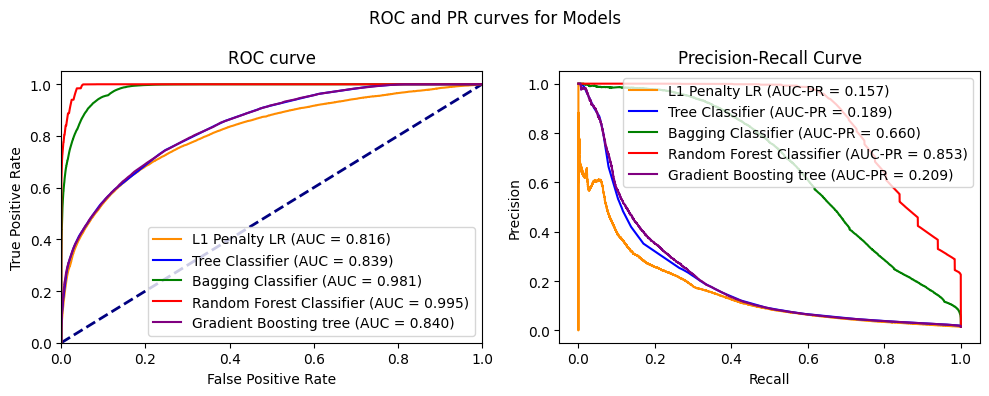

In [34]:
#Training Results
list_train_probs = [grid_search_l1.predict_proba(df_train.loc[:,df_numeric_features])[:,1],
                    grid_search_tree.predict_proba(df_train.loc[:,df_numeric_features])[:,1],
                    grid_search_bagging.predict_proba(df_train.loc[:,df_numeric_features])[:,1],
                    grid_search_forest.predict_proba(df_train.loc[:,df_numeric_features])[:,1],
                    grid_search_xgboost.predict_proba(df_train.loc[:,df_numeric_features])[:,1]]

labels = ['L1 Penalty LR','Tree Classifier','Bagging Classifier', 'Random Forest Classifier', 'Gradient Boosting tree']
draw_roc_prc(df_train['outcome'], list_train_probs, labels)

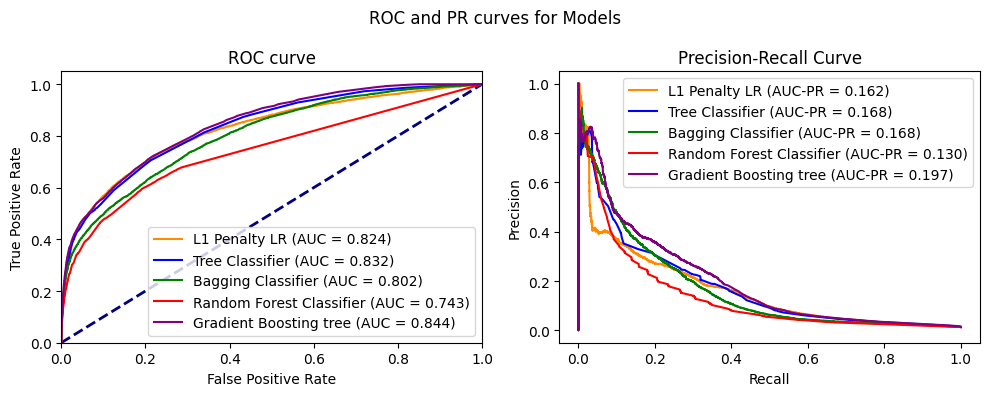

In [35]:
#Validation Results
list_val_probs = [grid_search_l1.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_tree.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_bagging.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_forest.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_xgboost.predict_proba(df_val.loc[:,df_numeric_features])[:,1]]

labels = ['L1 Penalty LR','Tree Classifier','Bagging Classifier', 'Random Forest Classifier', 'Gradient Boosting tree']
draw_roc_prc(df_val['outcome'], list_val_probs, labels)

Clearly both Bagging and Random Forest Classifier's are both overfitting because of the small number of trees used (really slow to train). I'm going to try to fix the parameters and increase the number of trees to see if they improve.

In [47]:
rand_for_optimized = RandomForestClassifier(n_estimators=200, n_jobs=-1).fit(df_train.loc[:,df_numeric_features], df_train['outcome'])
bagging_optimized = BaggingClassifier(n_estimators=200, max_features = 0.5, max_samples = 0.5, n_jobs=-1).fit(df_train.loc[:,df_numeric_features], df_train['outcome'])

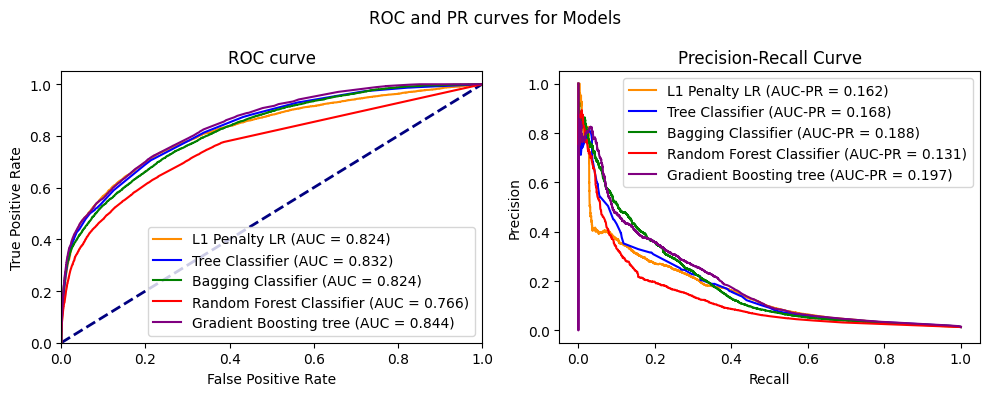

In [48]:
#Validation Results New
list_val_probs = [grid_search_l1.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_tree.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    bagging_optimized.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    rand_for_optimized.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_xgboost.predict_proba(df_val.loc[:,df_numeric_features])[:,1]]

labels = ['L1 Penalty LR','Tree Classifier','Bagging Classifier', 'Random Forest Classifier', 'Gradient Boosting tree']
draw_roc_prc(df_val['outcome'], list_val_probs, labels)

They both improved but still behind the XGBoost Model

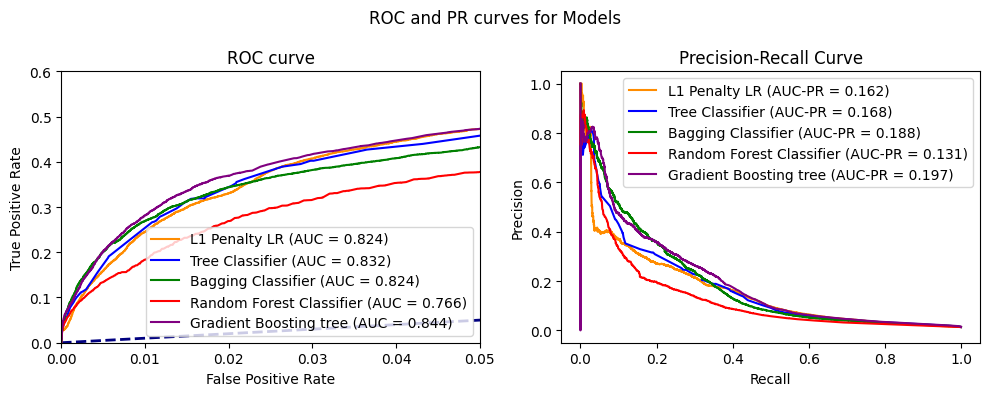

In [49]:
draw_roc_prc(df_val['outcome'], list_val_probs, labels,[0,0.05],[0,0.6])

Even though Bagging performs worse in terms of AUC, we can see how for small FPR, which are the values we are going to be work with, it is as good as the gradient boosting tree model.

Lets Check if Categorical Variables and Date Variables make any difference for the best performing model.

In [37]:
#XG Boost with categorical + Date features
all_features =  df_numeric_features+df_categorical_features+df_date_features
grid_search_xgboost_all_feat = get_model_xgboost(df_train.loc[:,all_features])


/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/zrive-ds-GYwyIoqR-py3.11/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is d

{'clf__learning_rate': 0.01, 'clf__n_estimators': 200}


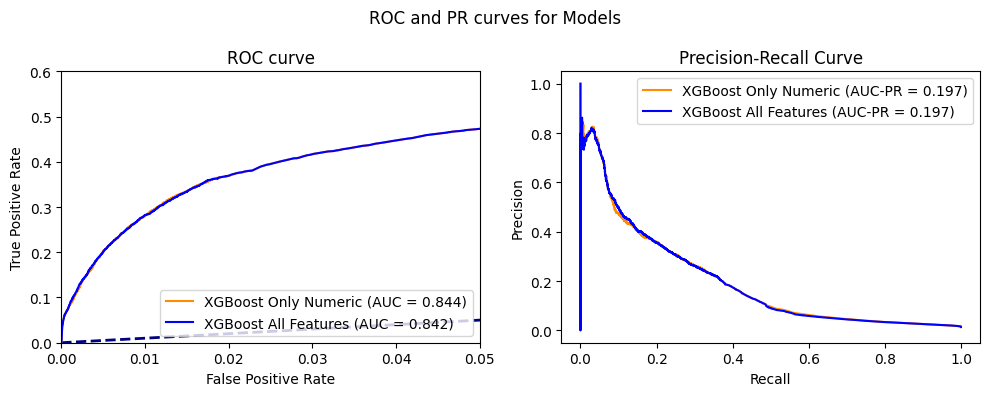

In [38]:
#Checking it for ROC from 0 to 0.05%

print(grid_search_xgboost_all_feat.best_params_)

draw_roc_prc(df_val['outcome'], 
             [grid_search_xgboost.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
              grid_search_xgboost_all_feat.predict_proba(df_val.loc[:,all_features])[:,1]],
              ['XGBoost Only Numeric','XGBoost All Features'],
              [0,0.05],
            [0,0.6])

No Improvement. The model used will then be the one with only numeric features for computational reasons. 

### Test Results

In [39]:
print(metrics.confusion_matrix(df_test['outcome'],grid_search_xgboost.predict(df_test.loc[:,df_numeric_features])))
print(metrics.accuracy_score(df_test['outcome'],grid_search_xgboost.predict(df_test.loc[:,df_numeric_features])))
print(metrics.f1_score(df_test['outcome'],grid_search_xgboost.predict(df_test.loc[:,df_numeric_features])))

[[217878     20]
 [  2683    138]]
0.987753659630571
0.09264853977844915


The model used will be then a XGBoost model with hyperparameters {'clf__learning_rate': 0.01, 'clf__n_estimators': 200}